### Signal filtering
* [x] Low-pass/high-pass filter
* [x] Band-pass/band-stop filter
* [ ] Comb filter
* [x] Spectral subtraction
* [x] Wiener filter
* [ ] Subspace filter
* [ ] Kalman filter

### VAD(Voice Acitivity Detection)
* [x] Threshold VAD
* [x] Zero-crossing-detection VAD
* [ ] GMM-based VAD

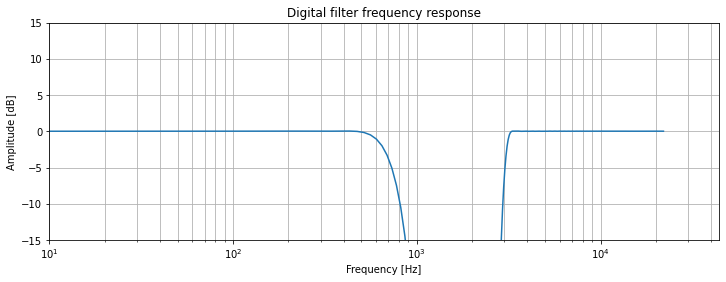

In [62]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import math

fs = 44100
nyq = fs / 2.0  # ナイキスト周波数

# フィルタの設計
# ナイキスト周波数が1になるように正規化
fe1 = 750.0 / nyq       # カットオフ周波数1
fe2 = 3000.0 / nyq      # カットオフ周波数2
numtaps = 255           # フィルタ係数（タップ）の数（要奇数）

# b = signal.firwin(numtaps, fe1)                         # Low-pass
# b = signal.firwin(numtaps, fe2, pass_zero=False)        # High-pass
# b = signal.firwin(numtaps, [fe1, fe2], pass_zero=False) # Band-pass
b = signal.firwin(numtaps, [fe1, fe2])                  # Band-stop

# フィルタ係数の保存
np.savetxt("parmBS750-3000", b, fmt='% 7f')
w, h = signal.freqz(b)

plt.figure(figsize=(12, 4))  # (width, height)
plt.title('Digital filter frequency response')
plt.xscale("log")

amp_db = 20 * np.log10(abs(h))
f = w / (2 * np.pi) * fs
plt.plot(f, amp_db)
plt.title('Digital filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.xlim(10, 44100)
plt.ylim([-15,15])
plt.grid(which='both', axis='both')
plt.show()

In [266]:
import os

cur_dir = os.getcwd()
work_dir = os.path.join(cur_dir, "noise_reduction")

# print(f"work_dir: {work_dir}")

In [40]:
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.io import wavfile
import soundfile as sf
import os
import pyroomacoustics as pra
import librosa

In [120]:
def calc_SNR(s_level, n_level):
    return 20 * np.log10(s_level/n_level)

def calc_RMS(amp):
    return np.sqrt(np.mean(np.square(amp), axis=-1))

In [131]:
# SNR of input signal (assumed SNR)
snr = 5
speech_file = work_dir + "/input/male_angry_16k.wav"
noise_file = work_dir + "/noisy_input/pink_noise_16k.wav"

# load WAV files, both files require same sampling rates
signal, fs = sf.read(speech_file, always_2d=True)
noise, fs_n = sf.read(noise_file, always_2d=True)
print(fs, fs_n)
assert fs == fs_n
signal = signal[:, 0]
noise = noise[:, 0]

# truncate to same length
print(signal.shape, noise.shape)
if len(signal) < len(noise):
    noise = noise[:len(signal)]
else:
    signal = signal[:len(noise)]

# weight noise according to desired SNR
signal_level = np.linalg.norm(signal) # calc level
noise_level = np.linalg.norm(noise) # calc level
noise_desired_level = signal_level / 10**(snr / 20)
noise_fact = noise_desired_level / noise_level
noise_weighted = noise_fact * noise

cur_snr = calc_SNR(signal_level, noise_level)
new_snr = calc_SNR(signal_level, np.linalg.norm(noise_weighted))

print(f"signal_level {signal_level}, noise_level {noise_level}")
print(f"current SNR[dB] {cur_snr}")
print(f"desired SNR[dB] {snr}, calculated SNR[dB] {new_snr}")

# add signal and noise
noisy_signal = signal + noise_weighted
noisy_signal /= np.abs(noisy_signal).max()
print(f"mean of noisy signal {noisy_signal.mean()}")
noisy_signal -= noisy_signal.mean() # force zero centering???

16000 16000
(668000,) (480000,)
signal_level 66.12078271082967, noise_level 102.56048404825947
current SNR[dB] -3.8128415192260556
desired SNR[dB] 5, calculated SNR[dB] 5.0000000000000036
mean of noisy signal 0.0009701601218666756


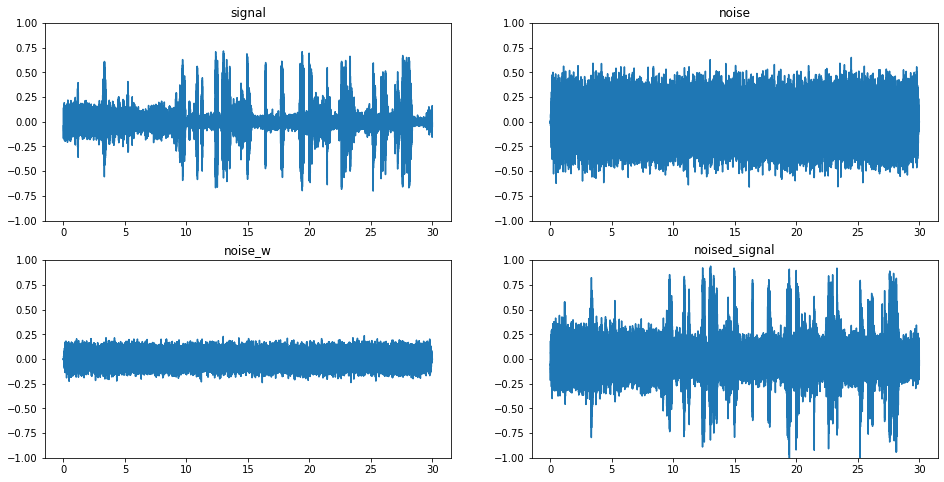

In [132]:
duration = len(signal) / fs
time_axis = np.linspace(0, duration, len(signal))

n_fig = 4
fig = plt.figure(figsize=(16, 8))

titles = ["signal", "noise", "noise_w", "noised_signal"]
y = [signal, noise, noise_weighted, noisy_signal]
for i in range(n_fig):
    fig.add_subplot(n_fig//2,n_fig//2,i+1)
    plt.title(titles[i])
    plt.plot(time_axis, y[i])
    plt.ylim(-1, 1)

In [55]:
ipd.Audio(noisy_signal, rate=fs)

### Spectral Gain methods
* Spectral subtraction
* Wiener filter
* Subspace filter

In [118]:
# STFT parameters
window_len = 512
hop = fft_len // 2  # half overlap
window = pra.hann(window_len, flag='asymmetric', length='full')

# number of points to perform FFT
nfft = 512

# Maximum suppression per frequency bin.
# Large suppresion can result in more musical noise.
db_reduc = 10

# How many frames to look back for the noise floor estimate.
lookback = 5

# An overestimation factor to "push" the suppression towards db_reduc.
beta = 5

# An exponential factor to tune the suppresion
# (see documentation of 'SpectralSub').
alpha = 1

# Hann window
window = pra.hann(nfft, flag='asymmetric', length='full')

# create objects
stft = pra.transform.STFT(nfft, hop=nfft // 2, analysis_window=window)
scnr = pra.denoise.SpectralSub(nfft, db_reduc, lookback, beta, alpha)

# collect the processed blocks
denoised_signal = pra.denoise.apply_spectral_sub(noisy_signal, nfft, db_reduc, lookback, beta, alpha).astype(np.float32)
# denoised_signal = denoised_signal * np.iinfo(np.int16).max => これをやるとファイルが書き込めても読み込んだ時に音声が残らない
# denoised_signal = denoised_signal.astype(np.int16)
print(denoised_signal.dtype)

# n = 0
# while noisy_signal.shape[0] - n > hop:

#     # SCNR in frequency domain
#     stft.analysis(noisy_signal[n: n + hop])
#     gain_filt = scnr.compute_gain_filter(stft.X)

#     # back to time domain
#     denoised_signal[n: n + hop] = stft.synthesis(gain_filt * stft.X)
    
#     # update step
#     n += hop

# output results
outputDir = work_dir + '/output'
os.makedirs(outputDir, exist_ok=True)

print(denoised_signal.max(), denoised_signal.min())
print("Output denoised speech.")
wavfile.write("{}/denoised_speech.wav".format(outputDir), fs, denoised_signal)

ipd.Audio(denoised_signal, rate=fs)

float32
0.9166165 -0.8874555
Output denoised speech.


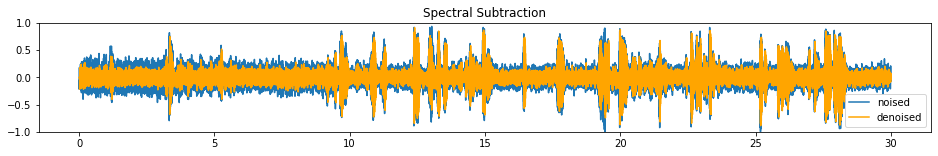

In [201]:
duration = len(denoised_signal) / fs
time_axis = np.linspace(0, duration, len(denoised_signal))

fig = plt.figure(figsize=(16, 2))
fig.tight_layout()

plt.title("Spectral Subtraction")
plt.plot(time_axis, noisy_signal, label="noised")
plt.plot(time_axis, denoised_signal, color="orange", label="denoised")
plt.ylim(-1, 1)
plt.legend()
plt.show()

### 音声区間検出
* VAD(Voice Activity Detection)

### 閾値ベースVAD

0.716064453125 -0.701141357421875
0.5127483010292053 0.0


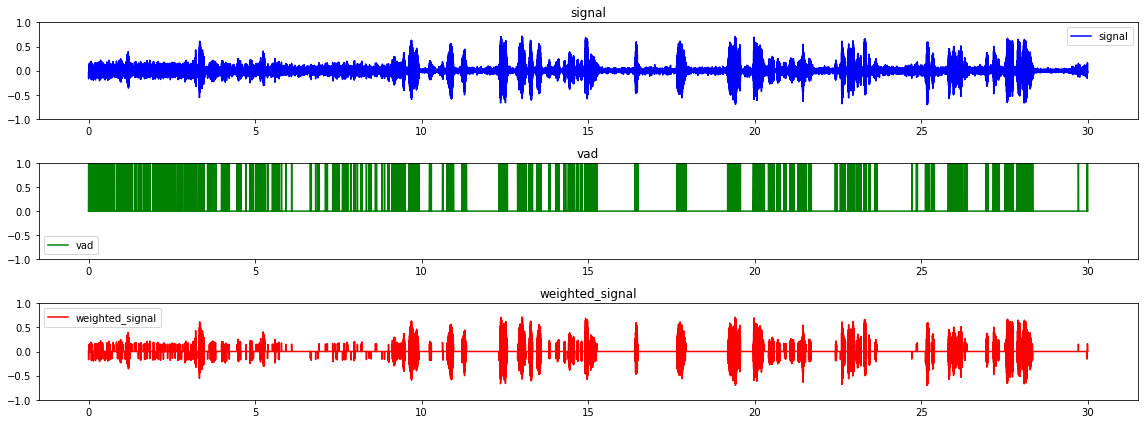

In [258]:
power = signal**2

print(signal.max(), signal.min())
print(power.max(), power.min())

# Percent of masking
alpha = 0.02
vad = np.where(power > alpha, 1.0, 0)
w_vad = np.where(vad > 0, 1.0, 0)

duration = len(signal) / fs
time_axis = np.linspace(0, duration, len(signal))

fig = plt.figure(figsize=(16, 6), tight_layout=True)

titles = ["signal", "vad", "weighted_signal"]
y = [signal, vad, signal*w_vad]
c = ["blue", "green", "red"]

n_fig = 3
for i in range(n_fig):
    fig.add_subplot(n_fig,1,i+1)
    plt.title(titles[i])
    plt.plot(time_axis, y[i], color=c[i], label=titles[i])
    plt.ylim(-1, 1)
    plt.legend()

plt.show()

In [259]:
ipd.Audio(signal, rate=fs)

In [260]:
ipd.Audio(signal*vad, rate=fs)

### ゼロ交差検知ベースVAD
無声子音も認識するためには零交差数を使います。零交差数とは音声信号がある時間領域の中で振幅の正負が何回入れ替わるか、を表す数値<br>
参考：https://www.ai-shift.co.jp/techblog/1093<br>
ただし、SNRが低い環境(雑音環境下)だと、上手くいかないらしい。。。->ゼロ交差点が低いのが無声子音と識別可能？

In [222]:
window = 512
pad = np.zeros(len(signal)%window)
signal_arr = np.concatenate([signal, pad])

zero_cross = np.zeros(signal.shape)
for w_idx in range(len(signal)):
    w_arr = signal_arr[w_idx:w_idx+window]
    zero_cross[w_idx] = 0.5 * np.abs(np.sign(w_arr[:-1]) - np.sign(w_arr[1:])).sum()

(480000,) 1


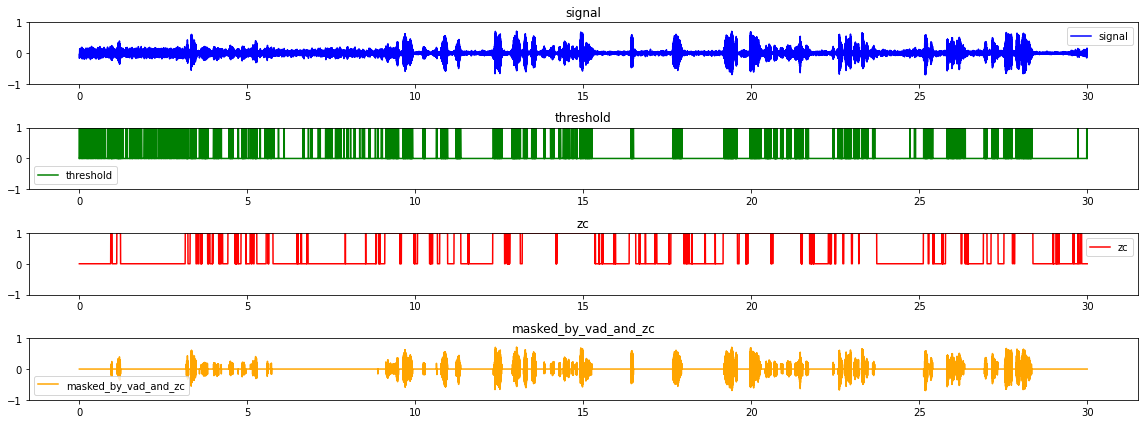

In [267]:
# threshold of zero-crossing-rate 50
zc = np.where(zero_cross > 10, 1, 0)
print(zc.shape, zc.max())

duration = len(signal) / fs
time_axis = np.linspace(0, duration, len(signal))

fig = plt.figure(figsize=(16, 6), tight_layout=True)

titles = ["signal", "threshold", "zc", "masked_by_vad_and_zc"]
y = [signal, vad, zc, signal*(vad*zc)]
c = ["blue", "green", "red", "orange"]

n_fig = 4
for i in range(n_fig):
    fig.add_subplot(n_fig,1,i+1)
    plt.title(titles[i])
    plt.plot(time_axis, y[i], color=c[i], label=titles[i])
    plt.ylim(-1, 1)
    plt.legend()

plt.show()

In [263]:
ipd.Audio(signal*(zc), rate=fs)

In [264]:
ipd.Audio(signal*(vad*zc), rate=fs)